<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/U-Nets/Image_segmentation_Unet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with U-Net

We'll be buil an U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/U-Nets/notebook_images/carseg.png" style="width:500px">
  <figcaption><u><b>Figure 1</u></b>: Example of a segmented image <br></figcaption>
</figure>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

In this notebook we will:

* Build our own U-Net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction


<a name='1'></a>
## 1 - Packages


In [ ]:
import os
import shutil
from zipfile import ZipFile

import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import tensorflow.python.framework.ops as tfops

import imageio
import matplotlib.pyplot as plt
%matplotlib inline

#from test_utils import summary, comparator

In [ ]:
# Installing packages without !pip
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [ ]:
install_package('wget')
import wget

install_package('ipdb')
import ipdb
#%pdb on

install_package('gdown')
import gdown

Installing wget ...
Package wget has been successfully installed
Reloading Packages
Installing ipdb ...
Package ipdb has been successfully installed
Reloading Packages
Package: gdown is already installed. Skipping installation
Reloading Packages


<a name='2'></a>
## 2 - Load and Split the Data

In [ ]:
# Copying data from Github to session
_DATA_DIR = './data'
_DATA_RGB_ZIP = 'CameraRGB.zip'
_DATA_MASK_ZIP = 'CameraMask.zip'

if not os.path.isdir(_DATA_DIR):
  os.mkdir(_DATA_DIR)

_DATA_RGB_PATH=os.path.join(_DATA_DIR, _DATA_RGB_ZIP)
if not os.path.isfile(_DATA_RGB_PATH):
  gdown.download('https://drive.google.com/u/0/uc?id=1Pi6a4Rvqc-XhYjTrLUEIhIO2KTEXddgA&export=download&confirm=t', _DATA_RGB_PATH, quiet=False)
  with ZipFile(_DATA_RGB_PATH, 'r') as zippy:
    zippy.extractall(_DATA_DIR)

_DATA_MASK_PATH=os.path.join(_DATA_DIR, _DATA_MASK_ZIP)
if not os.path.isfile(_DATA_MASK_PATH):
  gdown.download('https://drive.google.com/u/0/uc?id=1PiVoa4TMXnI0L8qFt9S4QCKEsIRW-_qL&export=download&confirm=t', _DATA_MASK_PATH, quiet=False)
  with ZipFile(_DATA_MASK_PATH, 'r') as zippy:
    zippy.extractall(_DATA_DIR)

# Remove default sample_data directory
if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

Downloading...
From: https://drive.google.com/u/0/uc?id=1Pi6a4Rvqc-XhYjTrLUEIhIO2KTEXddgA&export=download&confirm=t
To: /content/data/CameraRGB.zip
100%|██████████| 529M/529M [00:06<00:00, 78.7MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1PiVoa4TMXnI0L8qFt9S4QCKEsIRW-_qL&export=download&confirm=t
To: /content/data/CameraMask.zip
100%|██████████| 15.7M/15.7M [00:00<00:00, 67.9MB/s]


Removing default sample_data directory...


In [ ]:
_DATA_RGB_DIR = './data/CameraRGB'
_DATA_MASK_DIR = './data/CameraMask'

IMAGE_LIST = os.listdir(_DATA_RGB_DIR)
MASK_LIST  = os.listdir(_DATA_MASK_DIR)
IMAGE_LIST = [os.path.join(_DATA_RGB_DIR, file) for file in IMAGE_LIST]
MASK_LIST  = [os.path.join(_DATA_MASK_DIR, file) for file in MASK_LIST]

<a name='3'></a>
## 3 - Utilities

In [ ]:
BOLD_ON ='\033[1m'
BOLD_OFF='\033[0m'
def print_bold(text):
  print(BOLD_ON+text+BOLD_OFF)

In [ ]:
def render_images(images=None, labels=None, display_text=True, zoom=1.0):
  """
  render original and segmented images one next to the other

  Arguments:
    images - a list of (HxWx3) arrays - Min Length = 1 ; Max Length = 3 (Eager Tensors are also processed)
    seg_image - a (HxWx3) array
    org_name - str containing the name of the image (default: Unspecified)
    display_text (default: True)
    zoom - float (default: 1.0)
  """

  L = len(images)
  assert L >= 1 and L <= 3, 'The number of pictures should be in the interval 1-3'

  if labels == None:
    labels = ['Unspecified'] * L
  assert L == len(labels), 'The name of the labels should be equal to the name of images'

  fig, ax = plt.subplots(nrows=1, ncols=L, figsize=(16*zoom,9*zoom))
  for i, image in enumerate(images):
    # Check if the instance is of type EagerTensor and preprocess if needed
    if isinstance(image, tfops.EagerTensor):
      image = tf.keras.preprocessing.image.array_to_img(image)
    else:
      # Check for dimensions and correct shape if needed
      if len(image.shape) == 4 and image.shape[0] == 1:
        image = np.squeeze(image, axis=0)

    ax[i].imshow(image)
    ax[i].set_title(labels[i])

  plt.show()

Let's display some of the examples in the training set

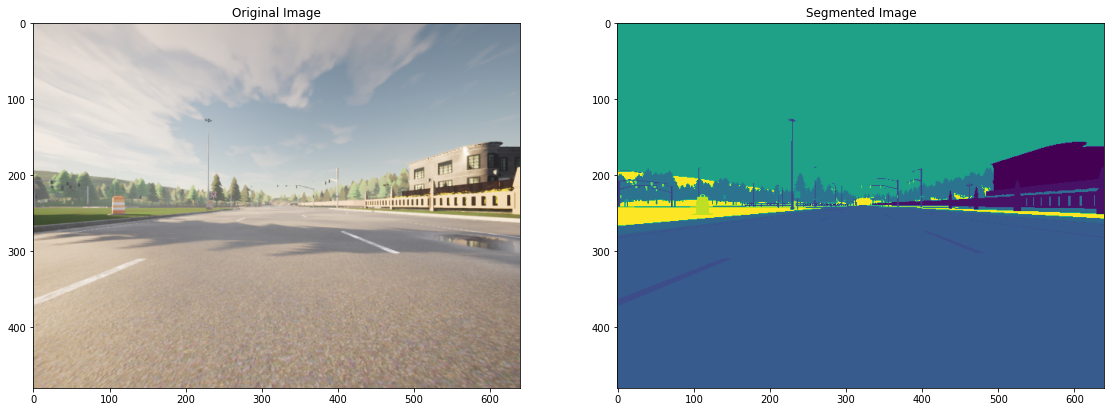

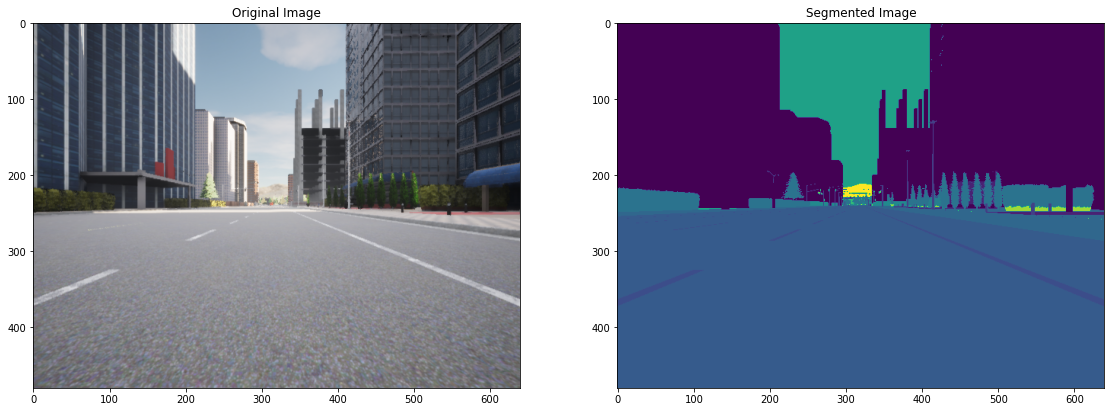

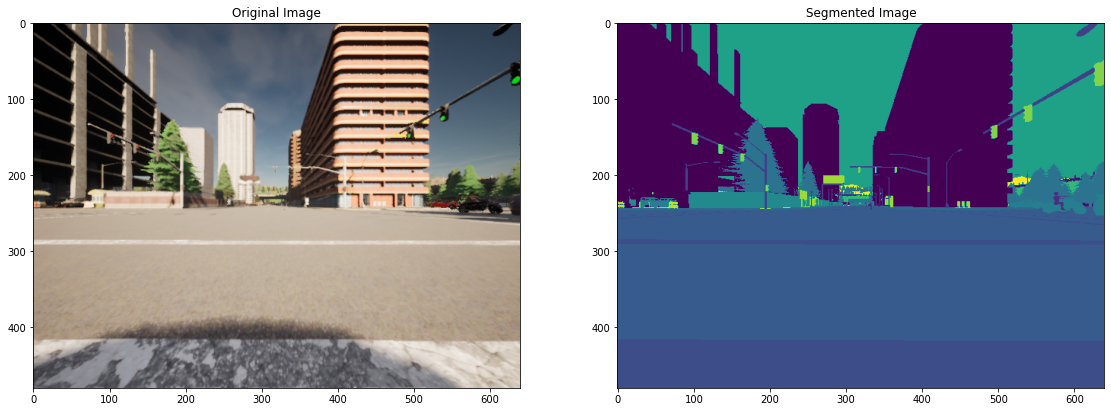

In [ ]:
indices = [np.random.randint(0, len(IMAGE_LIST)) for i in range(3)]
for i in indices:
  img = imageio.imread(IMAGE_LIST[i])
  mask = imageio.imread(MASK_LIST[i])[:,:, 0]
  render_images(images=[img, mask], labels=['Original Image', 'Segmented Image'], zoom=1.2)

<a name='2'></a>
# 2 - Handling Datasets with TensorFlow


<a name='2.1'></a>
## 2.1 - Splitting The Dataset

In this notebook we will use a more elaborated (yet, less intuitive) representation of the dataset using pipelines.
This representation allows a better scaling and integration into platforms like TensorFlow Extended (TFX)!
Every variable will be stored as a tf.Tensor including information like shape, dtype, numpy value

In [ ]:
# Creating tuples of tensors containing the filenames of both sets
images_ds = tf.data.Dataset.list_files(IMAGE_LIST, shuffle=False)
masks_ds  = tf.data.Dataset.list_files(MASK_LIST, shuffle=False)

for path in zip(images_ds.take(5), masks_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000029.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000029.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000032.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000032.png'>)


Some info about zip and take below

In [ ]:
help(zip)

Help on class zip in module builtins:

class zip(object)
 |  zip(*iterables) --> zip object
 |  
 |  Return a zip object whose .__next__() method returns a tuple where
 |  the i-th element comes from the i-th iterable argument.  The .__next__()
 |  method continues until the shortest iterable in the argument sequence
 |  is exhausted and then it raises StopIteration.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [ ]:
help (tf.data.Dataset.take)

Help on function take in module tensorflow.python.data.ops.dataset_ops:

take(self, count, name=None)
    Creates a `Dataset` with at most `count` elements from this dataset.
    
    >>> dataset = tf.data.Dataset.range(10)
    >>> dataset = dataset.take(3)
    >>> list(dataset.as_numpy_iterator())
    [0, 1, 2]
    
    Args:
      count: A `tf.int64` scalar `tf.Tensor`, representing the number of
        elements of this dataset that should be taken to form the new dataset.
        If `count` is -1, or if `count` is greater than the size of this
        dataset, the new dataset will contain all elements of this dataset.
      name: (Optional.) A name for the tf.data operation.
    
    Returns:
      Dataset: A `Dataset`.



In [ ]:
# Tensorizing the lists
images_filenames = tf.constant(IMAGE_LIST)
print(f'images_filenames type: \t{type(images_filenames)}')

masks_filenames = tf.constant(MASK_LIST)
print(f'masks_filenames type: \t{type(masks_filenames)}')

# Creating a dataset from the lists using from_tensor_slices
dataset = tf.data.Dataset.from_tensor_slices((images_filenames, masks_filenames))
print(f'dataset type: \t{type(dataset)}')

for image, mask in dataset.take(3):
  print(f'\nimage value={image} \t type={type(image)} \t shape={image.shape} \t type={image.dtype} \t numpy()={image.numpy()}')
  print(f'mask value={mask} \t type={type(mask)} \t shape={mask.shape} \t type={mask.dtype} \t numpy()={mask.numpy()}')

images_filenames type: 	<class 'tensorflow.python.framework.ops.EagerTensor'>
masks_filenames type: 	<class 'tensorflow.python.framework.ops.EagerTensor'>
dataset type: 	<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>

image value=b'./data/CameraRGB/007783.png' 	 type=<class 'tensorflow.python.framework.ops.EagerTensor'> 	 shape=() 	 type=<dtype: 'string'> 	 numpy()=b'./data/CameraRGB/007783.png'
mask value=b'./data/CameraMask/007783.png' 	 type=<class 'tensorflow.python.framework.ops.EagerTensor'> 	 shape=() 	 type=<dtype: 'string'> 	 numpy()=b'./data/CameraMask/007783.png'

image value=b'./data/CameraRGB/002943.png' 	 type=<class 'tensorflow.python.framework.ops.EagerTensor'> 	 shape=() 	 type=<dtype: 'string'> 	 numpy()=b'./data/CameraRGB/002943.png'
mask value=b'./data/CameraMask/002943.png' 	 type=<class 'tensorflow.python.framework.ops.EagerTensor'> 	 shape=() 	 type=<dtype: 'string'> 	 numpy()=b'./data/CameraMask/002943.png'

image value=b'./data/CameraRGB/00

<a name='5'></a>
## 2.2 - Preprocessing the Datasets

Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

In [ ]:
def process_path(image_path, mask_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

  return img, mask

def preprocess(image, mask):
  input_image = tf.image.resize(image, (96, 128), method='nearest')
  input_mask = tf.image.resize(mask, (96, 128), method='nearest')
  
  return input_image, input_mask

# Defining two mappings, each for each function
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
type(image_ds)
type(processed_image_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
print(image_ds)
print(processed_image_ds)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>


<a name='3'></a>
# 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

<a name='3-1'></a>
### 3.1 - Model Details

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/U-Nets/notebook_images/unet.png" style="width:500px">
  <figcaption><u><b> Figure 2 </u></b>: U-Net Architecture<br> </figcaption>
</figure>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.


<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/U-Nets/notebook_images/encoder.png" style="width:500px">
  <figcaption> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </figcaption>
</figure>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  


In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True, name=""):
  """
  Convolutional downsampling block
  
  Arguments:
      inputs -- Input tensor
      n_filters -- Number of filters for the convolutional layers
      dropout_prob -- Dropout probability
      max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
      name -- the basis for the layer name
  
  Returns: 
      next_layer, skip_connection --  Next layer and skip connection outputs
  """

  conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', name=name+"_conv1")(inputs)
  conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', name=name+"_conv2")(conv)

  if dropout_prob > 0:
    conv = Dropout(dropout_prob, name=name+"_drop1")(conv)

  if max_pooling:
    next_layer = MaxPooling2D(pool_size=(2, 2), name=name+"_max_2D_1")(conv)
  else:
    next_layer = conv
      
  skip_connection = conv
  
  return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<figure align="center">
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/U-Nets/notebook_images/decoder.png" style="width:500px">
  <figcaption> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </figcaption>
</figure>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Exercise 2 - upsampling_block

Implement `upsampling_block(...)`.

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* Your `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where you'll concatenate the outputs from the encoder blocks, creating skip connections. 

* Concatenate your Conv2DTranspose layer output to the contractive input, with an `axis` of 3. In general, you can concatenate the tensors in the order that you prefer. But for the grader, it is important that you use `[up, contractive_input]`

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, name=""):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
        name -- the base for the layer naming
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(n_filters, kernel_size=3, strides=(2,2), padding='same', name=name+'_Conv_2DT_1')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3, name=name+'_concat_1')
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', name=name+'_Conv_1')(merge)
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', name=name+'_Conv_2')(conv)
    return conv

<a name='3-4'></a>
### 3.4 - Building the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
  """
  Builds the U-NET architecture
  
  Arguments:
      input_size -- Input shape 
      n_filters -- Number of filters for the convolutional layers
      n_classes -- Number of output classes
  Returns: 
      model -- tf.keras.Model
  """
  inputs = Input(input_size)

  # CONTRACTING PATH
  cblock1 = conv_block(inputs=inputs, n_filters=n_filters, name='cblock1')
  cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2, name='cblock2')
  cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4, name='cblock3')
  cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3, name='cblock4') 
  cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False, name='cblock5') 
  
  # EXPANDING PATH
  ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters=n_filters*8, name='ublock6')
  ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters=n_filters*4, name='ublock7')
  ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters=n_filters*2, name='ublock8')
  ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters=n_filters*1, name='ublock9')

  # OUTPUT LAYERS
  conv9 = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal', name='conv9')(ublock9)
  conv10 = Conv2D(n_classes, 1, padding='same', name='conv10')(conv9)
  
  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

Check out the model summary below! 

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 cblock1_conv1 (Conv2D)         (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 cblock1_conv2 (Conv2D)         (None, 96, 128, 32)  9248        ['cblock1_conv1[0][0]']          
                                                                                                  
 cblock1_max_2D_1 (MaxPooling2D  (None, 48, 64, 32)  0           ['cblock1_conv2[0][0]']      

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [ ]:
unet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling


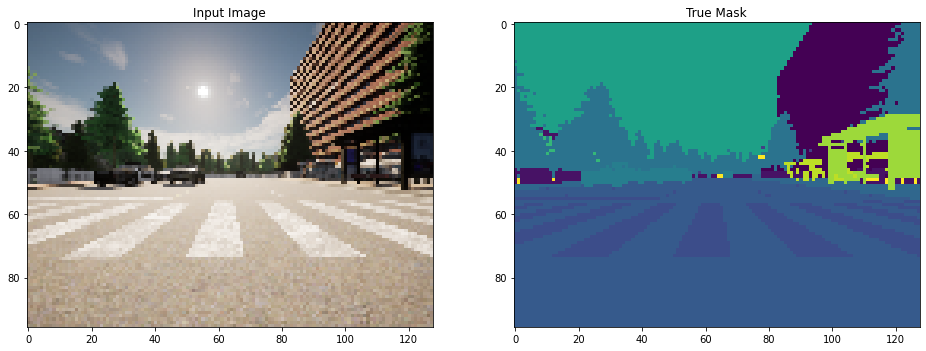

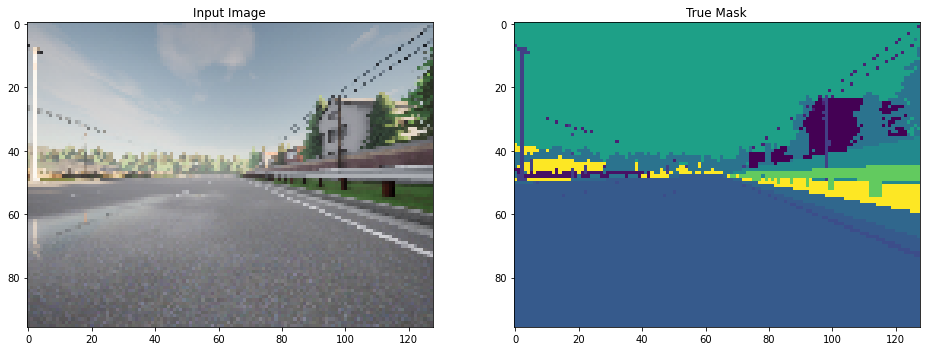

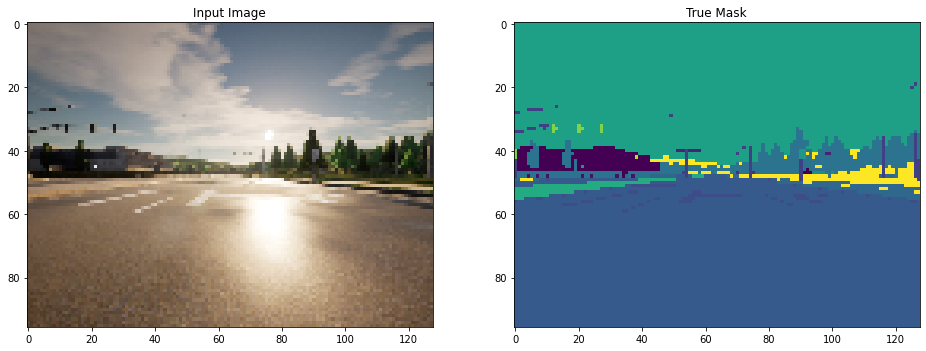

In [ ]:
for image, mask in processed_image_ds.take(3):
  render_images(images=[image, mask], labels=['Input Image', 'True Mask'])

<a name='3.8'></a>
## 3.8 - Train the Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 48s 426ms/step - loss: 2.1982 - accuracy: 0.3481
Epoch 2/40
34/34 [==============================] - 5s 136ms/step - loss: 0.7841 - accuracy: 0.7938
Epoch 3/40
34/34 [==============================] - 5s 137ms/step - loss: 0.5375 - accuracy: 0.8429
Epoch 4/40
34/34 [==============================] - 5s 138ms/step - loss: 0.4369 - accuracy: 0.8732
Epoch 5/40
34/34 [==============================] - 5s 139ms/step - loss: 0.3615 - accuracy: 0.8906
Epoch 6/40
34/34 [==============================] - 5s 142ms/step - loss: 0.3068 - accuracy: 0.9091
Epoch 7/40
34/34 [==============================] - 5s 142ms/step - loss: 0.2787 - accuracy: 0.9179
Epoch 8/40
34/34 [==============================] - 5s 142ms/step - loss: 0.2682 - accuracy: 0.9204
Epoch 9/40
34/34 [==============================] - 5s 143ms/step - loss: 0.21

**Create Predicted Masks**

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

**Plot Model Accuracy**

Let's see how your model did! 

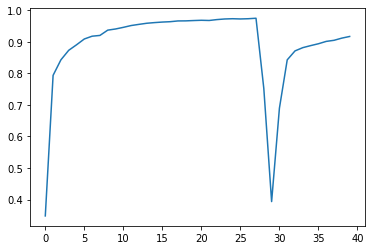

In [ ]:
plt.plot(model_history.history["accuracy"])

<a name='3-9'></a>
## 3.9 - Testing the model

Next, check your predicted masks against the true mask and the original input image:

In [ ]:
def make_predictions(dataset=None, num=1, render=False):
  """
  Displays the first image of each of the num batches
  """
  predicted_masks=[]
  labelled_masks=[]

  for batch_images, batch_masks in dataset.take(num):
    batch_pred_masks = unet.predict(batch_images)
    batch_pred_masks = create_mask(batch_pred_masks)

    predicted_masks.append(batch_pred_masks)
    labelled_masks.append(batch_masks)
    
    if render:
      render_images(images=[batch_images[0], batch_masks[0], batch_pred_masks[0]], labels=['Original', 'Mask', 'Predicted'])

  return predicted_masks, labelled_masks

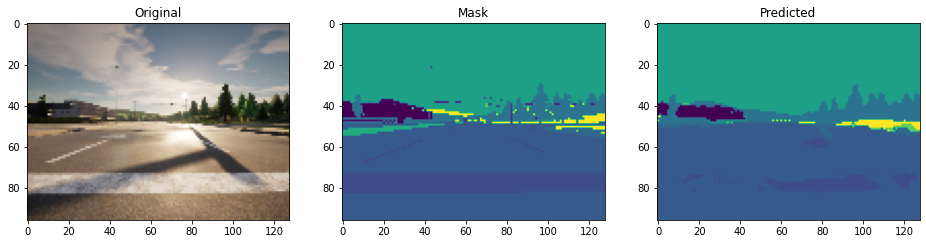

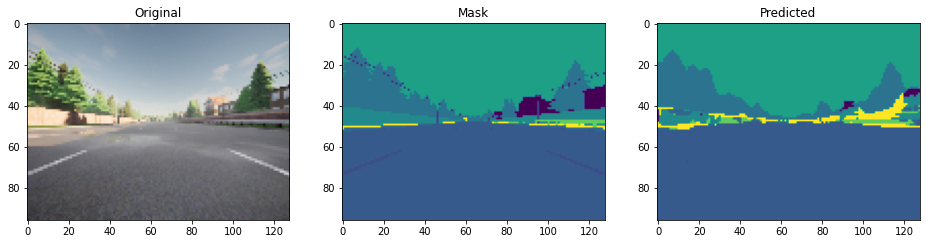

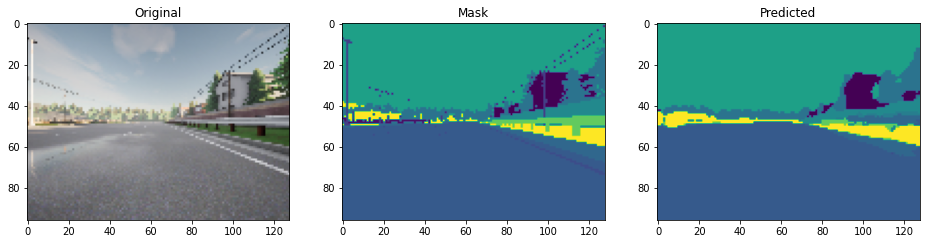

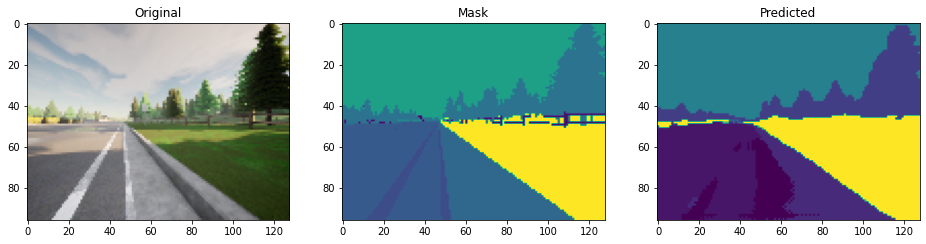

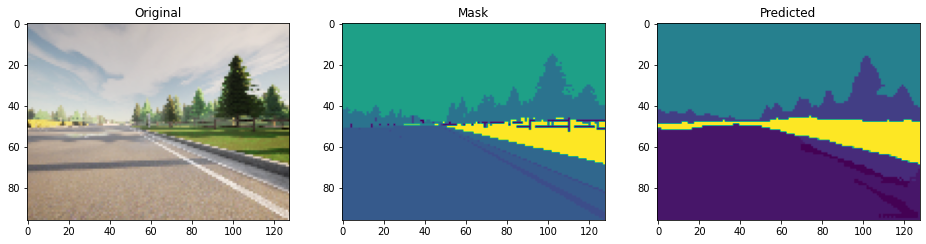

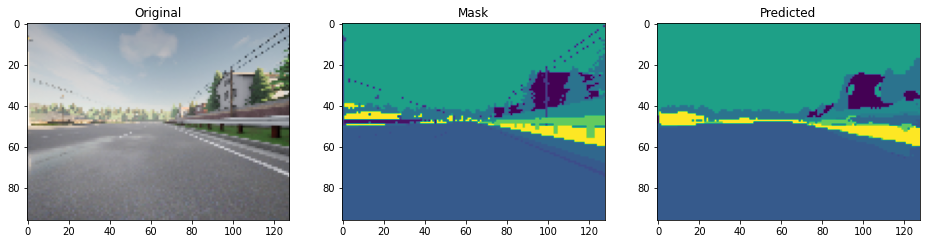

In [ ]:
predicted_masks, labelled_masks = make_predictions(train_dataset, 6, render=True)

With 40 epochs you get amazing results!

Yet, it is very difficult to analytically compare between the training mask and the predicted one. Let's implement a function to do that.


In [ ]:
def score_masks(labelled_masks, predicted_masks):
  no_batches = len(labelled_masks)

  score = 0
  total = 0
  for c in range(no_batches):
    lab_masks = np.array(labelled_masks[c])
    prd_masks = np.array(predicted_masks[c])

    shape = lab_masks.shape
    N, H, W, D = shape

    score+=np.sum(lab_masks==prd_masks)
    total+=N*H*W*D

  return np.round(score/total, 3)

In [ ]:
score_masks(labelled_masks, predicted_masks)

0.917

This was the accuracy for a single glorious batch. Now lets compute the accuracy for all of them and average them.

In [ ]:
predicted_masks, labelled_masks = make_predictions(train_dataset, num=34, render=False)

In [ ]:
score_masks(labelled_masks, predicted_masks)

0.923

# 4 - Improving the U-NET Model

92.3% score is not bad, but yet not great. Let's try changing the parameters of the training and see how this affects the final result.
In this try, I multiplied the batch size as well as the number of epochs.

In [ ]:
EPOCHS = 80
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 64
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/80
17/17 [==============================] - 31s 990ms/step - loss: 0.2490 - accuracy: 0.9249
Epoch 2/80
17/17 [==============================] - 5s 277ms/step - loss: 0.2391 - accuracy: 0.9282
Epoch 3/80
17/17 [==============================] - 5s 278ms/step - loss: 0.2296 - accuracy: 0.9310
Epoch 4/80
17/17 [==============================] - 5s 280ms/step - loss: 0.2248 - accuracy: 0.9326
Epoch 5/80
17/17 [==============================] - 5s 281ms/step - loss: 0.2161 - accuracy: 0.9351
Epoch 6/80
17/17 [==============================] - 5s 280ms/step - loss: 0.2131 - accuracy: 0.9358
Epoch 7/80
17/17 [==============================] - 5s 277ms/step - loss: 0.2117 - accuracy: 0.9361
Epoch 8/80
17/17 [==============================] - 5s 276ms/step - loss: 0.2019 - accuracy: 0.9394
Epoch 9/80
17/17 [==============================] - 5s 274ms/step - loss: 0.29

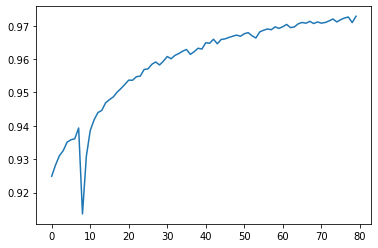

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
len(train_dataset)

17

In [ ]:
predicted_masks, labelled_masks = make_predictions(train_dataset, num=17, render=False)

In [ ]:
score_masks(labelled_masks, predicted_masks)

0.973

Much Better! :-)